# Task

The task is to design a neural network that can solve a sentiment polarity task. The network should include a transformer-based language model.

# Some installations and imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.8 MB/s 
     |████████████████████████████████| 6.6 MB 42.3 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 58.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from torchvision import transforms
import tensorflow as tf
import transformers
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm # for creating a progress bar
import matplotlib.pyplot as plt # for creating a plot

# Load data

I use the Large Movie Review Dataset, downloadable at this website: https://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
import urllib.request
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
filename = 'data.tar.gz'
urllib.request.urlretrieve(url, filename)

('data.tar.gz', <http.client.HTTPMessage at 0x7f74bdd14390>)

In [ ]:
import tarfile
import os

# extract tar gz 
file = tarfile.open('data.tar.gz')
file.extractall()
file.close()

In [ ]:
path_neg_test = './aclImdb/test/neg'
dir_list_neg_test = os.listdir(path_neg_test)
path_pos_test = './aclImdb/test/pos'
dir_list_pos_test = os.listdir(path_pos_test)
path_neg_train = './aclImdb/train/neg'
dir_list_neg_train = os.listdir(path_neg_train)
path_pos_train = './aclImdb/train/pos'
dir_list_pos_train = os.listdir(path_pos_train)

# create empty lists X_raw_pos and X_raw_neg 
X_raw_test = []
X_raw_train = []

# iterate over file-name-lists, add file contents to X_raw_train and X_raw_test
for dir in dir_list_neg_test:
    new_file = open(f'./aclImdb/test/neg/{dir}', "r")
    file_content = new_file.read()
    X_raw_test.append(file_content)
    new_file.close()

for dir in dir_list_pos_test:
    new_file = open(f'./aclImdb/test/pos/{dir}', "r")
    file_content = new_file.read()
    X_raw_test.append(file_content)
    new_file.close()

for dir in dir_list_neg_train:
    new_file = open(f'./aclImdb/train/neg/{dir}', "r")
    file_content = new_file.read()
    X_raw_train.append(file_content)
    new_file.close()

for dir in dir_list_pos_train:
    new_file = open(f'./aclImdb/train/pos/{dir}', "r")
    file_content = new_file.read()
    X_raw_train.append(file_content)
    new_file.close()

# prepare y_train
y_neg = [0 for i in range(len(dir_list_neg_train))]
y_pos = [1 for i in range(len(dir_list_pos_train))]
y_train = y_neg + y_pos

# prepare y_test
y_neg_test = [0 for i in range(len(dir_list_neg_test))]
y_pos_test = [1 for i in range(len(dir_list_pos_test))]
y_test = y_neg_test + y_pos_test

# turn y_train and y_test into numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# The model

The model consists of a layer of the transformer model Bert, and of a sequential layer for classification, consisting of a linear and a sigmoid layer.

In [ ]:
class Bert_model(nn.Module):
  def __init__(self, lr, n_epochs, X_train, X_test, y_train, y_test):
    super(Bert_model, self).__init__()
    self._bert = transformers.BertModel.from_pretrained('bert-base-uncased')    # initializing the bert layer
    self._clf = nn.Sequential(nn.Linear(768,1), nn.Sigmoid())                   # initializing a sequential layer consisting of a linear layer 
                                                                                # and a sigmoid layer
    self.tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') # initializing the bert tokenizer
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.lr = lr
    self.train_loss = list() 
    self.train_accuracy = list() 
    self.n_epochs = n_epochs
    self.batch_size = 16

    use_cuda = torch.cuda.is_available()                                        # check if cuda is available
    if use_cuda:                                                                # if yes, GPU is used for computation
      self.cuda()


  def tokenize_data(self, X):
    encoding = self.tokenizer(X, add_special_tokens=True, truncation=True,  # encode the data using the tokenizer, return pytorch tensors
                                     padding="longest", return_attention_mask=True, return_tensors="pt")
    return encoding


  def forward(self, X):
    _, c = self._bert(**X, return_dict=False)                                   # forward pass the data through the bert layer
    return self._clf(c)                                                         # pass data through the classifier layer and return it



  def fitting(self):
    loss_function = nn.BCELoss()                                                # initialize loss function, binary entropy loss
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)                 # initialize optimizer Adam

    for epoch in range(self.n_epochs):
      
      # load training data
      trainloader = torch.utils.data.DataLoader([[self.X_train[i], self.y_train[i]] for i in range(len(self.X_train))], shuffle=True, batch_size=self.batch_size)

      with tqdm(trainloader, unit="batch", desc="Epoch %i" % epoch) as batches: # create progress bar
        for review, target in batches:                                          # loop over reviews and targets
          tokenized = self.tokenize_data(review)                                # tokenize batch
          tokenized['input_ids'] = tokenized['input_ids'].cuda()                # move values of the dictionary returned by the tokenizer to cuda
          tokenized['token_type_ids'] = tokenized['token_type_ids'].cuda()
          tokenized['attention_mask'] = tokenized['attention_mask'].cuda()

          target = target.cuda()                                                # move the target to cuda

          optimizer.zero_grad()                                                 # reset the gradients to zero

          output = self(tokenized)                                              # forward pass, returns a tensor of 0s and 1s (Sigmoid is last layer)

          output = output.view(-1)                                              # flatten output (1-dimensional)

          target_float = target.float()                                         # turn target into floats (loss function doesn't accept integers)

          loss = loss_function(output, target_float)                            # calculate loss

          loss.backward()                                                       # backward pass (compute gradients)
          
          optimizer.step()                                                      # update the model parameters

          rounded_output = torch.round(output)                                  # round elements in output to 0s and 1s

          matches = (rounded_output == target_float).sum().item()               # calculate how many matches between output and target
        
          total = len(output)                                                   # how many reviews in the batch

          accuracy = 100*(matches / total)                                      # calculate accuracy
          batches.set_postfix(loss=loss.item(), accuracy=accuracy)              # add loss and accuracy to the progress bar

          self.train_accuracy.append(accuracy)                                  # add accuracy to list, will be used for plotting
          self.train_loss.append(loss.item())                                   # add loss to list, will be used for plotting


  def predict(self):
    # load test data
    testloader = torch.utils.data.DataLoader([[self.X_test[i], self.y_test[i]] for i in range(len(self.X_test))], shuffle=True, batch_size=self.batch_size)

    with torch.no_grad():                                                       # Do not use the following forward passes to calculate a gradient
      matches = 0                                                             
      for review, target in testloader:                                         # loop over reviews and targets
        tokenized = self.tokenize_data(review)                                  # tokenize batch
        tokenized['input_ids'] = tokenized['input_ids'].cuda()                  # move values of the dictionary returned by the tokenizer to cuda
        tokenized['token_type_ids'] = tokenized['token_type_ids'].cuda()
        tokenized['attention_mask'] = tokenized['attention_mask'].cuda()

        target = target.cuda()                                                  # move the target to cuda
      
        scores_batch = self(tokenized).view(-1)                                 # forward pass, returns a tensor of 0s and 1s (Sigmoid is last layer), flattened
        matches += (torch.round(scores_batch) == target).sum().item()           # calculate how many matches between batch scores and target

      total = len(self.X_test)                                                  # length of test data (number of reviews in test set)

    return 100* (matches / total)                                               # return test set accuracy
    


try_model = Bert_model(0.00005, 1, X_raw_train, X_raw_test, y_train, y_test)    # create an instance of the class, send it to cuda

try_model.fitting()                                                             # fit (train) the model

accuracy = try_model.predict()                                                  # predict accuracy on test set
print("test accuracy: ", accuracy)
     

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Epoch 0: 100%|██████████| 1563/1563 [38:22<00:00,  1.47s/batch, accuracy=87.5, loss=0.23]


test accuracy:  92.824


# Random baseline

As we can see, the random baseline is a lot lower than the model's test accuracy.

In [ ]:
from random import randint
matches = [randint(0, 1) for i in range(25000)]                                 # create a list of random 0s and 1s
total = len(X_raw_test)                                                         # length of test data (number of reviews in test set)

print("Random baseline: ", (100* (sum(matches) / total)))    

Random baseline:  50.424


# Testing functions' running time

Some code I used for figuring out which parts of the code were slow and needed to be improved.

In [ ]:
!pip install line-profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 4.5 MB/s 


In [ ]:
%load_ext line_profiler

In [ ]:
#%lprun -f try_model.fitting try_model.fitting() # test fitting function

# Plot over loss and accuracy during training

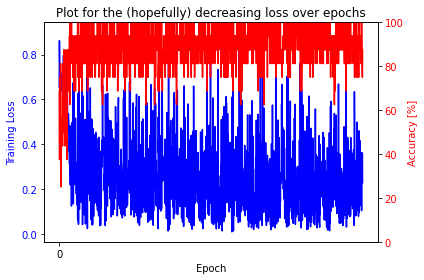

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
ax.plot(try_model.train_loss, 'b-')
ax.set_ylabel("Training Loss", color='b')
ax.set_xlabel("Epoch")
# ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='b')
ax = ax.twinx()
ax.plot(try_model.train_accuracy, 'r-')
ax.set_ylabel("Accuracy [%]", color='r')
ax.tick_params(axis='y', labelcolor='r')
a = list(ax.axis())
a[2] = 0
a[3] = 100
ax.axis(a)
t = np.arange(0, len(try_model.train_accuracy), len(try_model.X_train)//try_model.batch_size+1)
ax.set_xticks(ticks=t)
ax.set_xticklabels(labels=np.arange(len(t)))
fig.tight_layout()
plt.show()